In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

from eval_helpers import get_eval_single

In [166]:
all_datasets = {
    'adult_new': 'svm', 
    'adult_old': 'lr' #, 'public', 'taiwan'
}
curr_dataset = 'adult_new'

In [159]:
methods_to_cols = {
    # 'pleiss': ['scores_fpr', 'scores_tpr', 'scores_eo'], 
    'feldman': ['scores_pr','scores_tpr','scores_eo','scores_acc']
}

In [167]:
us_overthresholds_all = pd.read_csv('../results/' + curr_dataset + '_' + all_datasets[curr_dataset] + '__evalthresholds.csv')
feldman_overthresholds = pd.read_csv(curr_dataset + '_results/feldman__overthresholds.csv') # pr, tpr, eo, acc 

orig = us_overthresholds_all.loc[us_overthresholds_all['lambda'] == 'orig'][['tpr_A', 'tpr_B', 'fpr_A', 'fpr_B', 'acc_overall']] 
full = us_overthresholds_all.loc[us_overthresholds_all['lambda'] == 'full'][['tpr_A', 'tpr_B', 'fpr_A', 'fpr_B', 'acc_overall']] 
us_tpr = us_overthresholds_all.loc[us_overthresholds_all['lambda'] == 'tpr'][['tpr_A', 'tpr_B', 'fpr_A', 'fpr_B', 'acc_overall']] 
us_eqodds = us_overthresholds_all.loc[us_overthresholds_all['lambda'] == 'eo_1'][['tpr_A', 'tpr_B', 'fpr_A', 'fpr_B', 'acc_overall']]
feldman = feldman_overthresholds[['thresholds', 'tpr_differences_scores_tpr', 'fpr_differences_scores_tpr',
                                'tpr_A_scores_eo', 'tpr_B_scores_eo',
                                'fpr_A_scores_eo', 'fpr_B_scores_eo', 
                                'acc_overall_scores_tpr',
                                'acc_overall_scores_eo',                             
                                ]]

### table

In [94]:
def get_10_trials(maindf, colnames):
    metrics_per_trial = pd.DataFrame(columns=[
        'trial', 'thresholds'
    ])

    for i in range(10):
        print("processing trial", i)
        currdf = maindf.loc[maindf.trial == i]
        curreval = pd.DataFrame()
        for j in range(len(colnames)):
            col = colnames[j]
            currcoleval = get_eval_single(currdf.label, currdf[col], currdf.group)
            if j == 0:
                curreval['thresholds'] = currcoleval['thresholds'].values
            currcoleval.drop(columns=['thresholds'], inplace=True)
            currcoleval.rename(columns={oldcol: oldcol + '_' + col for oldcol in currcoleval.columns}, inplace=True)
            
            curreval = pd.concat([curreval, currcoleval], axis=1)

        curreval['trial'] = i
        metrics_per_trial = pd.concat([metrics_per_trial, curreval], ignore_index=True)

    return metrics_per_trial
    
def get_results_overthresholds(dataset):
    for method in methods_to_cols:
        print("===== ", method, " =====")
        scores = pd.read_csv(dataset + '_results/' + method + '__scores.csv')
        overtrials = get_10_trials(scores, methods_to_cols[method])
        overtrials.to_csv(dataset + '_results/' + method + '__overthresholds.csv', index=False)

In [117]:
get_results_overthresholds(curr_dataset)

=====  feldman  =====
processing trial 0
processing trial 1
processing trial 2
processing trial 3
processing trial 4
processing trial 5
processing trial 6
processing trial 7
processing trial 8
processing trial 9


In [111]:
def _single_cell(vect):
    return (round(np.mean(vect), 3), round(np.std(vect), 3))

def feldman_summary(df):
    """
    for both rows of feldman
    """
    tpr_tpr = np.abs(df.tpr_differences_scores_tpr)
    eo_tpr = np.abs(df.tpr_differences_scores_tpr) + np.abs(df.fpr_differences_scores_tpr)
    acc_tpr = np.abs(df.acc_overall_scores_tpr)

    tpr_eo = np.abs(df.tpr_A_scores_eo - df.tpr_B_scores_eo)
    eo_eo = np.abs(df.tpr_A_scores_eo - df.tpr_B_scores_eo) + np.abs(df.fpr_A_scores_eo - df.fpr_B_scores_eo)
    acc_eo = np.abs(df.acc_overall_scores_eo)

    tpr_tpr_res = _single_cell(tpr_tpr)
    eo_tpr_res = _single_cell(eo_tpr)
    acc_tpr_res = _single_cell(acc_tpr)

    tpr_eo_res = _single_cell(tpr_eo)
    eo_eo_res = _single_cell(eo_eo)
    acc_eo_res = _single_cell(acc_eo)

    avgres = pd.DataFrame({
        'alg': ['feldman_tpr', 'feldman_eo'], 
        'tprdiff_mean': [tpr_tpr_res[0], tpr_eo_res[0]],
        'tprdiff_std': [tpr_tpr_res[1], tpr_eo_res[1]],
        'eodiff_mean': [eo_tpr_res[0], eo_eo_res[0]],
        'eodiff_std': [eo_tpr_res[1], eo_eo_res[1]], 
        'acc_mean': [acc_tpr_res[0], acc_eo_res[0]], 
        'acc_std': [acc_tpr_res[1], acc_eo_res[1]]

    })

    df['tpr_differences_tpr'] = tpr_tpr
    df['eqodds_differences_eqodds'] = eo_eo

    return avgres, df

def ours_summary(df, alg): 
    """
    for a single row of ours
    """
    tprqty = np.abs(df.tpr_A - df.tpr_B)
    eoqty = np.abs(df.tpr_A - df.tpr_B) + np.abs(df.fpr_A - df.fpr_B)
    acc = np.abs(df.acc_overall)

    tprres = _single_cell(tprqty)
    eqoptres = _single_cell(eoqty)
    accres = _single_cell(acc)

    avgres = pd.DataFrame({
        'alg': [alg],
        'tprdiff_mean': [tprres[0]],
        'tprdiff_std': [tprres[1]],
        'eodiff_mean': [eqoptres[0]],
        'eodiff_std': [eqoptres[1]], 
        'acc_mean': [accres[0]],
        'acc_std': [accres[1]]
    })

    df['tpr_differences'] = tprqty
    df['eqodds_differences'] = eoqty

    return avgres, df

In [118]:
summaries = pd.DataFrame(columns=['alg', 'tprdiff_mean', 'tprdiff_std', 'eodiff_mean', 'eodiff_std'])
summaries = pd.concat([summaries, ours_summary(orig, 'orig')[0]], ignore_index=True)
summaries = pd.concat([summaries, feldman_summary(feldman)[0]], ignore_index=True)
summaries = pd.concat([summaries, ours_summary(full, 'full/chzhen')[0]], ignore_index=True)
summaries = pd.concat([summaries, ours_summary(us_tpr, 'ours_tpr')[0]], ignore_index=True)
summaries = pd.concat([summaries, ours_summary(us_eqodds,'ours_eqodds')[0]], ignore_index=True)
summaries

/var/folders/r7/h3ndk1gd4vj1j8vgdg5vt8r00000gp/T/ipykernel_42879/982238586.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tpr_differences_tpr'] = tpr_tpr
/var/folders/r7/h3ndk1gd4vj1j8vgdg5vt8r00000gp/T/ipykernel_42879/982238586.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['eqodds_differences_eqodds'] = eo_eo


,alg,tprdiff_mean,tprdiff_std,eodiff_mean,eodiff_std,acc_mean,acc_std
0,orig,0.217,0.142,0.350,0.253,0.737,0.131
1,feldman_tpr,0.057,0.040,0.094,0.076,0.766,0.073
2,feldman_eo,0.063,0.042,0.103,0.079,0.766,0.074
3,full/chzhen,0.073,0.048,0.113,0.059,0.713,0.142
4,ours_tpr,0.022,0.016,0.029,0.022,0.719,0.143
5,ours_eqodds,0.020,0.014,0.027,0.018,0.719,0.143


In [119]:
summaries.to_csv(curr_dataset + '_results/__summarytable.csv')

### plotting

In [169]:
algs = {
    'uncorrected': ours_summary(orig, 'orig')[1],
    'full_corr': ours_summary(full, 'full')[1], 
    'ours_tpr': ours_summary(us_tpr, 'ours_tpr')[1],
    'ours_eqodds': ours_summary(us_eqodds, 'ours_eqodds')[1],
    'feldman': feldman_summary(feldman)[1], 
}
dataset_to_title = {
    'adult_old': 'Income - Sex',
    'adult_new': 'Income - Race',
    'public': 'Public Coverage - Race', 
    'taiwan': 'Taiwan Credit - Education'
}

/var/folders/r7/h3ndk1gd4vj1j8vgdg5vt8r00000gp/T/ipykernel_42879/982238586.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tpr_differences_tpr'] = tpr_tpr
/var/folders/r7/h3ndk1gd4vj1j8vgdg5vt8r00000gp/T/ipykernel_42879/982238586.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['eqodds_differences_eqodds'] = eo_eo


In [154]:
def plot_baselines_thresholds(metric, metrictitle, savefig=False, remove_legend=False): # metric either 'tpr' or 'eo'
    metr_overthresh = pd.DataFrame()
    for alg in ['uncorrected', 'full_corr', 'ours_tpr', 'feldman', 'ours_eqodds']:
        df = algs[alg]
        df['alg'] = alg 
        df['thresholds'] = (np.array([np.arange(101)*0.01]*10)).reshape(-1)

        metr_overthresh = pd.concat([metr_overthresh, df], ignore_index=True)

    # feldman
    algthresh = metr_overthresh.loc[metr_overthresh.alg == 'feldman']
    sns.lineplot(x=algthresh['thresholds'], y=algthresh[metric + '_differences_' + metric], label='Feldman (%s)'%metrictitle, linestyle='--', alpha=0.5, linewidth=1, err_kws={'alpha': 0.20}, color='cornflowerblue')

    algthresh = metr_overthresh.loc[metr_overthresh.alg == 'full_corr']
    sns.lineplot(x=algthresh['thresholds'], y=algthresh[metric + '_differences'], label='Jiang/Chzhen', linestyle='--', alpha=0.5, linewidth=1, err_kws={'alpha': 0.20}, color='mediumorchid')

    algthresh = metr_overthresh.loc[metr_overthresh.alg == 'ours_' + metric]
    # print(len(np.unique(algthresh[metric + '_differences'])))
    ax = sns.lineplot(x=algthresh['thresholds'], y=algthresh[metric + '_differences'], label='Ours (%s)'%metrictitle, linewidth=2, color='mediumseagreen')

    algthresh = metr_overthresh.loc[metr_overthresh.alg == 'uncorrected']
    sns.lineplot(x=algthresh['thresholds'], y=algthresh[metric + '_differences'], label='Unrepaired ($\lambda$=0)', linewidth=2, color='firebrick')

    sns.lineplot(x=algthresh['thresholds'], y=0*algthresh['thresholds'], linewidth=3,  label='Zero %s Difference'%metrictitle, alpha=0.4, color='silver')

    plt.title('%s Differences: '%metrictitle + dataset_to_title[curr_dataset], size=20)
    ax.set_ylabel("%s Differences"%metrictitle, fontsize=15)
    ax.set(xlabel=None)
    ax.set(ylabel=None)

    if remove_legend:
        ax.legend().remove()

    if savefig:
        plt.savefig('baseline_plots/__' + curr_dataset + '__%s_overthresh.png'%metric, bbox_inches='tight')

/var/folders/r7/h3ndk1gd4vj1j8vgdg5vt8r00000gp/T/ipykernel_42879/1824885876.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['alg'] = alg
/var/folders/r7/h3ndk1gd4vj1j8vgdg5vt8r00000gp/T/ipykernel_42879/1824885876.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['thresholds'] = (np.array([np.arange(101)*0.01]*10)).reshape(-1)


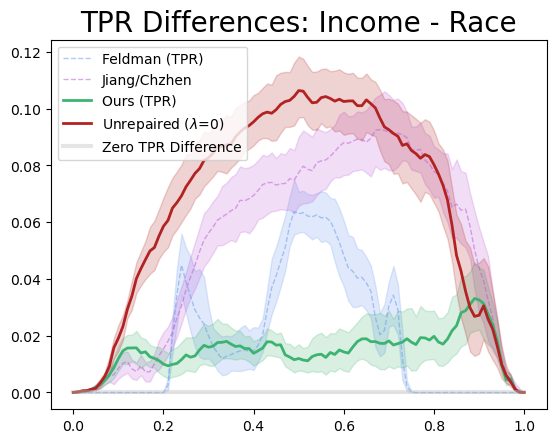

In [171]:
plot_baselines_thresholds('tpr', 'TPR', savefig=True)

/var/folders/r7/h3ndk1gd4vj1j8vgdg5vt8r00000gp/T/ipykernel_42879/1824885876.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['alg'] = alg
/var/folders/r7/h3ndk1gd4vj1j8vgdg5vt8r00000gp/T/ipykernel_42879/1824885876.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['thresholds'] = (np.array([np.arange(101)*0.01]*10)).reshape(-1)


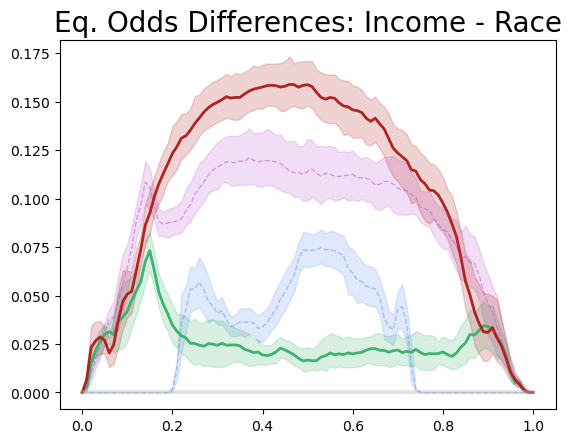

In [172]:
plot_baselines_thresholds('eqodds', 'Eq. Odds', remove_legend=True, savefig=True)

### hardt stuff

In [34]:
hardt_preds = pd.read_csv('adultold_results/hardt__preds.csv')
hardt_preds.head()

FileNotFoundError: [Errno 2] No such file or directory: 'adultold_results/hardt__preds.csv'

In [ ]:
hardt_evals = pd.DataFrame() #columns=eval_columns + ["thresholds", "trial"])
def get_hardt_eval(group, label, preds):
    acc = np.mean(label == preds)
    tpr_a = np.sum(preds[(group == 1) & (label[group == 1] == 1)]) / np.sum(label[group == 1] == 1)
    tpr_b = np.sum(preds[(group == 0) & (label[group == 0] == 1)]) / np.sum(label[group == 0] == 1)
    fpr_a = np.sum(preds[(group == 1) & (label[group == 1] == 1)]) / np.sum(label[group == 1] == 0)
    fpr_b = np.sum(preds[(group == 0) & (label[group == 0] == 1)]) / np.sum(label[group == 0] == 0)

    return {
        'acc_overall': acc,
        'tpr_differences': tpr_a - tpr_b,
        'fpr_differences': fpr_a - fpr_b
    }
for i in range(10):
    currdata = hardt_preds.loc[hardt_preds.trial == i]
    eval_ = get_hardt_eval(currdata.group, currdata.label, currdata.preds)
    eval_["trial"] = i 
    hardt_evals = hardt_evals.append(eval_, ignore_index=True)

In [ ]:
hardt = pd.read_csv(curr_dataset + '_results/hardt__preds.csv')
hardteval = pd.DataFrame()
from fairlearn.metrics import true_positive_rate, false_positive_rate

for i in range(10):
    currtrialhardt = hardt.loc[hardt.trial == i]
    acc = np.mean(currtrialhardt.preds == currtrialhardt.label)
    
    tpr_A = true_positive_rate(hardt.label[hardt.group == 1], hardt.preds[hardt.group == 1])
    
    tpr_B = true_positive_rate(hardt.label[hardt.group == 0], hardt.preds[hardt.group == 0])
    
    fpr_A = false_positive_rate(hardt.label[hardt.group == 1], hardt.preds[hardt.group == 1])
    fpr_B = false_positive_rate(hardt.label[hardt.group == 0], hardt.preds[hardt.group == 0])

    hardteval = hardteval.append({'trial': i, 'acc': acc, 'tpr_diff': tpr_A - tpr_B, 'fpr_diff': fpr_A - fpr_B}, ignore_index=True)

hardteval['eo_diff'] = np.abs(hardteval.tpr_diff) + np.abs(hardteval.fpr_diff)
hardteval.mean()